In [1]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

In [2]:
# Things to understand here:
# Portfolio
# Wallet
# proportion_order
# Order


from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)


class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            on_action = getattr(listener, "on_action", None)
            if callable(on_action):
                on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [3]:
# Things to understand here:
# Stream
# DataFeed

from tensortrade.env.default.rewards import TensorTradeRewardScheme, RiskAdjustedReturns, SimpleProfit
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [4]:
# Things to understand here:
# Writing a Renderer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [13]:
# Things to understand here:
# execution_order
# Types of execution logic
# Exchange
# DataFeed
# renderer_feed
# default (env)

import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio


def generate_sin_data():
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 100
    return y


def create_env(config):
    y = generate_sin_data()
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)

In [28]:
# Setting this flag to true will wrap the model in an LSTM
use_lstm = True

# Determine the size of the LSTM cell which will correspond to the size of the hidden state output of the LSTM
lstm_cell_size = 256

In [ ]:
analysis = tune.run(
    "PPO",
    stop={
        "episode_reward_mean": 500,
        "training_iteration": 20,
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25,
        },
        "log_level": "ERROR",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 3,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "model": {
            "use_lstm": use_lstm,
            "lstm_cell_size": lstm_cell_size
        },
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

In [ ]:
import ray.rllib.agents.ppo as ppo

checkpoint_metric = 'episode_reward_mean'

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(checkpoint_metric),
    metric=checkpoint_metric
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25,
        },
        "framework": "torch",
        "log_level": "ERROR",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "model": {
            "use_lstm": use_lstm,
            "lstm_cell_size": lstm_cell_size
        },
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

In [39]:
# See how the model is wrapped by LSTM
agent.get_policy().model

FullyConnectedNetwork_as_LSTMWrapper(
  (_hidden_layers): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=125, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch_separate): Sequential(
    (0): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=125, out_features=256, bias=True)
        (1): Tanh()
      )
    )
    (1): SlimFC(
      (_model): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
    )
  )
  (_value_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (lstm): LSTM(256, 256, batch_first=True)
  (_logits_branch): SlimFC(
    (_model): Sequential(
      (0): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)

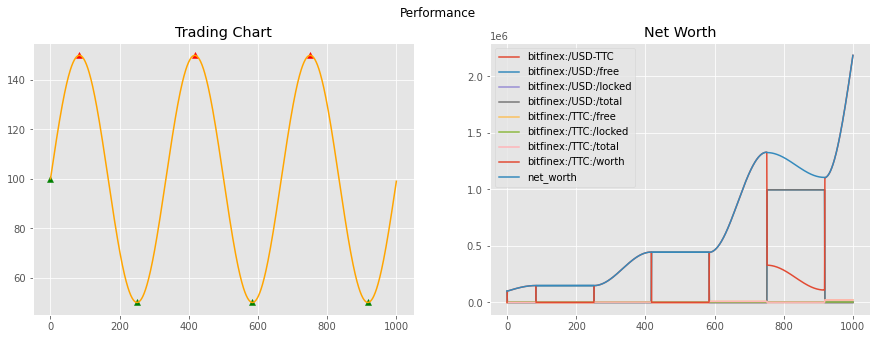

In [42]:
# Instantiate the environment
env = create_env({
    "window_size": 25,
})

# Run until episode ends
done = False
obs = env.reset()
# Initialize hidden_state variable that will correspond to lstm_cell_size
hidden_state = [np.zeros(lstm_cell_size), np.zeros(lstm_cell_size)]

i = 0
while not done:
    # In order for use_lstm to work we set full_fetch to True
    # This changes the output of compute action to a tuple (action, hidden_state, info)
    # We also pass in the previous hidden state in order for the model to use correctly use the LSTM
    action, hidden_state, _ = agent.compute_action(obs, state=hidden_state, full_fetch=True)
    obs, reward, done, info = env.step(action)

env.render()